# Линейная регрессия на синтетических данных

### Полезные ссылки:
<a href="https://numpy.org/">Numpy documentation</a><br />
<a href="https://pandas.pydata.org/">Pandas documentation</a><br />
<a href="https://matplotlib.org/">Matplotlib documentation</a><br />
<a href="https://scikit-learn.org/stable/">sklearn documentation</a><br />


In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Генерирация синтетических данных для задачи линейной регрессии
Эти данные моделируют линейную зависимость с вектором коэффициентов $\theta$ и задаваемой матрицей ковариаций для признаков $x^{(1)}$ и $x^{(2)}$:
$$
\theta=\begin{bmatrix}
2.33 \\
1.67 \\
-1.35
\end{bmatrix}
$$

По умолчанию (если не задана) матрица ковариаций следующая:
$$
R=\begin{bmatrix}
1.0 & 2.94\\
2.94 & 9.0
\end{bmatrix}
$$

Шум в данных моделируется следующим образом:
$$
\epsilon \sim \mathcal{N}(0, \sigma^2)\\
\sigma^2 = 1
$$

In [178]:
theta_true = np.array([[2.33, 1.67, -1.35]])
epsilon_var = 1.0
default_cov_matrix = np.array([[1.0, 2.94],
                               [2.94, 9.0]])

def generate_data(sample_size = 10000, cov_matrix = default_cov_matrix):
    
    X = np.random.multivariate_normal([0.0, 0.0], cov_matrix, sample_size)
    X_extended = np.hstack([np.ones((X.shape[0],1)), X])
    display(X_extended.shape)
    
    y = np.dot(X_extended, theta_true.T) +  np.random.randn(X_extended.shape[0],1)*np.sqrt(epsilon_var)
    return X,y

X,y = generate_data();


(10000, 3)

### Немного EDA для синтетических данных 

In [176]:
# EDA без pandas
print ('shape of X is', X.shape)
print ('std of X is', X.std(axis=0))
print ('corr matrix of X is \n', np.corrcoef(X.T))
print ('corr of Y and X is \n', [np.corrcoef (X[:,i], y.flatten())[0,1] for i in range (X.shape[1])])
#print ('corrs between Y and X is \n', [np.corrcoef(X.T))
display (np.corrcoef(X.T))

shape of X is (10000, 2)
std of X is [1.43713519 3.01979738]
corr matrix of X is 
 [[1.         0.70000827]
 [0.70000827 1.        ]]
corr of Y and X is 
 [-0.146454228327404, -0.7712349251789381]


array([[1.        , 0.70000827],
       [0.70000827, 1.        ]])

Text(0, 0.5, 'Y')

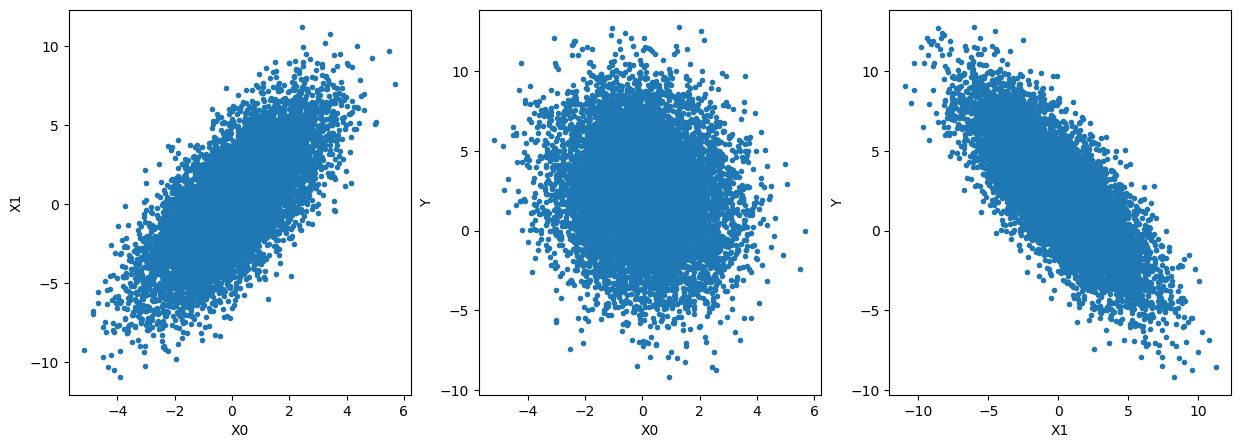

In [177]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(X[:,0], X[:,1], '.')
ax[0].set_xlabel('X0')
ax[0].set_ylabel('X1')

ax[1].plot(X[:,0], y, '.')
ax[1].set_xlabel('X0')
ax[1].set_ylabel('Y')

ax[2].plot(X[:,1], y, '.')
ax[2].set_xlabel('X1')
ax[2].set_ylabel('Y')


In [173]:
# EDA c pandas
df = pd.DataFrame({**{'Y': y.flatten()}, **{'X'+str(i):X[:,i] for i in range(X.shape[1])}})
display(df.head())
display(df.info())
print ('Descriptive stats')
display(df.describe())
print ('Corr matrix')
display(df.corr())

,Y,X0,X1
0,2.916152,0.040725,0.143917
1,6.345119,-1.168159,-4.449233
2,0.835362,0.781769,2.766485
3,4.349489,-1.217952,-3.246180
4,3.449262,-0.332770,-0.916281


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Y       10000 non-null  float64
 1   X0      10000 non-null  float64
 2   X1      10000 non-null  float64
dtypes: float64(3)
memory usage: 234.5 KB


None

Descriptive stats


,Y,X0,X1
count,10000.000000,10000.000000,10000.000000
mean,2.338596,-0.004964,-0.009271
std,2.650434,1.006863,3.021051
min,-7.244244,-3.952936,-12.215306
25%,0.596179,-0.698958,-2.069646
50%,2.321622,-0.017754,-0.019289
75%,4.161135,0.664362,2.025964
max,12.730934,3.501690,10.831991


Corr matrix


,Y,X0,X1
Y,1.000000,-0.874877,-0.916994
X0,-0.874877,1.000000,0.980568
X1,-0.916994,0.980568,1.000000


## Линейная регрессия своими руками

Ранее было продемонстрировано, что решение задачи линейной регрессии методом максимального правдоподобия эквивалентно решению оптимизационной задачи для функции среднеквадратического отклонения (записано для $n$-мерного случая, $N$ - число экземпляров в обучающей выборке):

$$
x_i = (x_{i}^{(0)}, x_{i}^{(1)}, \dots, x_{i}^{(n)})
$$

$$
\theta = (\theta^{(0)}, \theta^{(1)}, \dots, \theta^{(n)})
$$

$$
\theta^* = \underset{\Theta}{\mathrm{argmin}} \sum_{i=1}^{N}{\left( y_i-\theta\cdot x_i \right)^2}
$$

Для записи в матричном виде введем т.н. матрицу объекты-признаки:

$$
X = \begin{bmatrix}
x_{0}^{(0)} & x_{0}^{(1)} & \dots & x_{0}^{(n)} \\
x_{1}^{(0)} & x_{1}^{(1)} & \dots & x_{1}^{(n)} \\
\dots \\
x_{N}^{(0)} & x_{N}^{(1)} & \dots & x_{N}^{(n)}
\end{bmatrix}
$$

При этом не забываем, что нулевая компонента векторов описания всех объектов - единица.

Кроме этого введем вектор-столбец целевой переменной:
$$
Y = \begin{bmatrix}
y_{0}\\
y_{1}\\
\dots \\
y_{N}
\end{bmatrix}
$$


При этом важно, что $\theta$ - также вектор-столбец

Тогда функция ошибки может быть записана следующим образом:

$$
\mathscr{L}(\theta, X, Y) = \left(Y-X\cdot\theta\right)^T\cdot(Y-X\cdot\theta) = \\
{Y^T}{Y}-2\theta^T{X^T}{Y}+\theta^T{X^T}{X}{\theta}
$$

$$
\frac{\partial{\mathscr{L}(\theta, X, Y)}}{\partial{\theta}} = -2{X^T}{Y} + 2{X^T}X\theta
$$

Поскольку функция ошибка квадратична по $\theta$, можно утверждать, что у нее есть экстремум и он глобальный. Положение этого экстремума можно найти обычным образом:

$$
\frac{\partial{\mathscr{L}(\theta, X, Y)}}{\partial{\theta}} = 0
$$

Отсюда (можно воспользоваться [Matrix cookbook](https://www.math.uwaterloo.ca/~hwolkowi/matrixcookbook.pdf)):

$$
2{X^T}X\theta^* = 2{X^T}{Y}
$$

$$
\theta^* = (X^T X)^{-1} X^T Y 
$$

Осталось проверить, не максимум ли это. Для этого проверяем, что матрица вторых производных (по $\theta$) положительно определена:

$$
\frac{\partial^2 {\mathscr{L}(\theta, X, Y)}}{\partial\theta^2} = 2 X^T X
$$

In [140]:
class linear_regression:
    def __init__(self):
        self.theta = None
        pass
    
    def fit(self, X, y):
        assert X.ndim == 2, "X should be 2-dimensional: (N of objects, n of features)"
        assert ((y.ndim == 2)&(y.shape[1] == 1)), "y should be 2-dimensional: (N of objects, one column)"
        
        # attaching ones as first column-vector - x[:,0]
        X_0 = np.ones((X.shape[0], 1), dtype=float)
        X_matrix = np.concatenate([X_0, X], axis=1)
        
        # making y_train of shape (N,1)
        y_column = np.squeeze(np.asarray(y)).reshape((-1,1))
        
        m1 = np.dot(X_matrix.T, X_matrix)
        m2 = np.linalg.inv(m1)
        m3 = np.dot(m2, X_matrix.T)
        theta_star = np.dot(m3, y_column)
        self.theta = theta_star
    
    def predict(self, X):
        assert X.ndim == 2, "X should be 2-dimensional: (N of objects, n of features)"
        assert self.theta is not None, "theta is None. perhaps, fit the model first."
        
        X_0 = np.ones((X.shape[0], 1))
        X_matrix = np.concatenate([X_0, X], axis=1)
        y_pred = np.dot(X_matrix, self.theta)
        return y_pred

true theta is  [[ 2.33  1.67 -1.35]]
model theta is  [[ 2.32959056  1.69491851 -1.35426563]]
corr coeff is  0.926320181405079
R2 is  0.8580690784783378


Text(0, 0.5, 'Predicted')

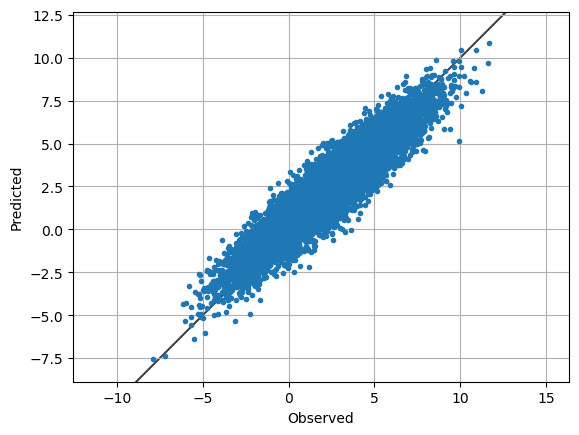

In [211]:
model = linear_regression()

model.fit(X, y)


y_pred = model.predict(X)

print('true theta is ', theta_true)
print('model theta is ', model.theta.T)

print ('corr coeff is ', np.corrcoef(y_pred.flatten(), y.flatten())[0,1])
print ('R2 is ', 1 - np.sum((y - y_pred)**2)/np.sum((y - np.mean(y))**2))


plt.figure()
plt.plot(y, y_pred, '.')
plt.axis('equal')
ax = plt.gca()
lims = [
       np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
       np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
       ]
plt.plot(lims, lims, 'k-', alpha=0.75, zorder=0)

plt.xlim(lims)
plt.ylim(lims)
plt.grid()
plt.xlabel('Observed')
plt.ylabel('Predicted')




### Линейная регрессия средствами библиотеки scikit-learn

In [203]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error


# model_sk = LinearRegression()
# model_sk.fit(X, y)


def add_ones(X):
   return np.concatenate([np.ones((X.shape[0], 1)), X], axis=1)

model_sk = LinearRegression(fit_intercept = False)
model_sk.fit (add_ones(X), y)




print('true theta is ', theta_true)
print('my model theta is ', model.theta.T)
print('SK model theta is ', model_sk.coef_)
print('SK model intercept is ', model_sk.intercept_)


true theta is  [[ 2.33  1.67 -1.35]]
my model theta is  [[ 2.32959056  1.69491851 -1.35426563]]
SK model theta is  [[ 2.32959056  1.69491851 -1.35426563]]
SK model intercept is  0.0


In [210]:
model_sk = LinearRegression()
model_sk.fit(X, y)
y_pred = model_sk.predict(X)

r = np.corrcoef(y_pred.flatten(), y.flatten())[0,1]
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)

print ('corr coeff is ', r)
print ('corr coeff^2 is ', r**2)

print ('R2 is ', r2)
print ('RMSE is ', np.sqrt (mse))


corr coeff is  0.9263201814050789
corr coeff^2 is  0.8580690784783382
R2 is  0.8580690784783378
RMSE is  0.9840952751053476
